In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree, neural_network, neighbors, discriminant_analysis

%matplotlib inline
plt.rcParams['figure.figsize'] = (4, 4) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Plot Training Sample and Mesh

In [2]:
def plot_classifier(Xtr, ytr, alpha = 0.2, alpha_pt = None, fn = None, h = 0.01, file = None):

    fig = plt.figure()
    
    if fn:
        
        xx, yy = np.meshgrid(np.arange(-1.3, 1.3, h),np.arange(-1.3, 1.3, h))
        Z = fn(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha = alpha)


    if alpha_pt: alpha = alpha_pt
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr, s=40, cmap=plt.cm.viridis, alpha = alpha, linewidth = 0.1)
    
    plt.xlim([-1.3, 1.3])
    plt.ylim([-1.3, 1.3])
    
    if file: fig.savefig(file, bbox_inches='tight', pad_inches=0.1)


## Define a Spiral Dataset

In [3]:
def spiral_data(K, N = 1000, D = 2, noise_level = 0.4):

    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):

        ix = range(N*j,N*(j+1))

        spiral = np.linspace(0, 1.5 * np.pi,N)
        offset = 2 * np.pi * j / K
        noise  = np.random.randn(N)*noise_level

        theta  = spiral + noise + offset

        r = np.linspace(0.0,1,N) # radius    

        X[ix] = np.c_[r*np.sin(theta), r*np.cos(theta)]
        y[ix] = j # class
        
    return X, y

## Define Blobs

In [4]:
def blob_data(X = 2, Y = 2, N = 1000, D = 2, correlated = 0.5, noise_level = 1.0):

    K = X * Y
    
    par = np.zeros((N*K,D))
    cat = np.zeros(N*K, dtype='uint8')
    
    xstart = -0.5 if X > 1 else 0
    ystart = -0.5 if Y > 1 else 0
    
    xx, yy = np.meshgrid(np.linspace(xstart, 0.5, X), 
                         np.linspace(ystart, 0.5, Y))
    
    for j, (xctr,yctr) in enumerate(zip(xx.ravel(), yy.ravel())):

        ix = range(N*j,N*(j+1))

        corr = np.random.randn(N) * correlated 
        uncorr_x = np.random.randn(N) * (1 - correlated)
        uncorr_y = np.random.randn(N) * (1 - correlated)

        x = (corr + uncorr_x) * noise_level + xctr
        y = (corr + uncorr_y) * noise_level + yctr

        r = np.linspace(0.0,1,N) # radius    

        par[ix] = np.c_[x, y]
        cat[ix] = j 
        
    return par, cat

## Build a Neural Network "By Hand"
Example adapted from these, which have the same form.  There are very, very nice notes in the Stanford class.  Here we use the bias trick, while they do not.  This makes it a bit simpler, but also requires care to adding and dropping the extra column.
* http://cs231n.github.io/neural-networks-case-study/
* http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
See "No Bias Trick" for a copy without explicit bias nodes.

In [5]:
import numpy as np

# Single hidden layer
class my_nn():
    
    def __init__(self, classes, dim, Nhidden = 100, step_size = 1, regularization = 1e-3):
        
        # dimensions
        self.K = classes
        self.D = dim
        self.Dh = Nhidden

        # randomly initialization
        # Use the bias trick: + 1
        self.W1 = 0.01 * np.random.randn(self.D  + 1, self.Dh)
        self.W2 = 0.01 * np.random.randn(self.Dh + 1, self.K)

        # hyperparameters
        self.step_size = step_size 
        self.a = regularization
        
    
    def evaluate(self, X):
        
        N = X.shape[0]
        
        # Useful to save the hidden layer, for back propagation.
        self.X = np.append(X, np.ones((N, 1)), axis = 1) # bias trick.
        hidden = np.maximum(0, np.dot(self.X, self.W1)) # ReLU activation
        self.h = np.append(hidden, np.ones((N, 1)), axis = 1) # bias trick.
        scores = np.dot(self.h, self.W2)
        
        return scores
 
    def classify(self, X):
        
        return np.argmax(self.evaluate(X), axis=1)
    
    def loss(self, X):
        
        # evaluate 
        scores = self.evaluate(X)

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        data_loss = np.sum(-np.log(probs[range(N),y])) / N
        regu_loss = 0.5 * self.a * (np.sum(self.W1*self.W1) + np.sum(self.W2*self.W2))
        
        return data_loss + regu_loss

    
    def train(self, X, y, iterations = 500, print_freq = 1000):
        
        N = X.shape[0]

        # gradient descent loop
        for it in range(iterations):

            # evaluate the scores.
            scores = self.evaluate(X)
            
            # compute the class probabilities
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

            # compute the gradient on scores
            df = probs
            df[range(N),y] -= 1
            df /= N

            # backpropate the gradient to the parameters
            # first backprop into W2 and regularize
            dW2 = np.dot(self.h.T, df) +  self.a * self.W2
            
            # Through the hidden layer, with ReLU 
            dh = np.dot(df, self.W2.T)
            dh[self.h <= 0] = 0
            
            # Now W1, dropping one from dimension for the bias node.
            # And add the regularization part
            dW1 = np.dot(self.X.T, dh[:,:-1]) + self.a * self.W1

            # perform a parameter update
            self.W1 -= self.step_size * dW1
            self.W2 -= self.step_size * dW2

            if it % print_freq == 0 and it:
                print('Iteraction {}, accuracy: {:.1f}%'.\
                      format(it, 100. * np.mean(nn.classify(X) == y)))



In [6]:
X, y = spiral_data(K = 5, noise_level = 0.2, N = 5000)

In [7]:
nn = my_nn(classes = len(set(y)), dim = X.shape[1], Nhidden = 100, regularization = 1e-4)

In [8]:
nn.train(X, y, iterations = 1001, print_freq = 100)

Iteraction 100, accuracy: 27.3%
Iteraction 200, accuracy: 30.1%
Iteraction 300, accuracy: 37.3%
Iteraction 400, accuracy: 47.0%
Iteraction 500, accuracy: 58.5%
Iteraction 600, accuracy: 70.0%
Iteraction 700, accuracy: 75.5%
Iteraction 800, accuracy: 78.4%
Iteraction 900, accuracy: 81.2%
Iteraction 1000, accuracy: 82.5%


Iteraction 100, accuracy: 83.5%
Iteraction 200, accuracy: 83.8%


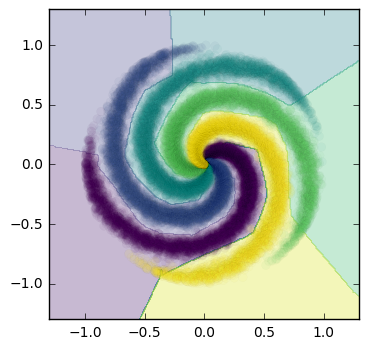

In [9]:
nn.step_size = 0.1
nn.train(X, y, 250, print_freq = 100)
plot_classifier(X[::,], y[::], fn = nn.classify, file = "my_nn_classifier.pdf", alpha = 0.3, alpha_pt = 0.05)